In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2021],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40883 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 291 ms, sys: 49.8 ms, total: 341 ms
Wall time: 349 ms


# 2021 

In [5]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2021,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [6]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [7]:
first_size = get_ddf_shape(data[config_year.year])

## Preprocessing

In [8]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 15.4 ms, sys: 2.98 ms, total: 18.4 ms
Wall time: 18 ms


In [9]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed -2 rows
dropped -3 columns
CPU times: user 159 ms, sys: 22.4 ms, total: 182 ms
Wall time: 1.24 s


In [10]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [11]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 662 ms, sys: 123 ms, total: 785 ms
Wall time: 4.83 s


In [12]:
nans

{}

In [13]:
zeros

{'num_bikes_available': 3.179841885137897,
 'num_bikes_available_types.mechanical': 13.69506730320022,
 'num_bikes_available_types.ebike': 24.63465094207253,
 'num_docks_available': 0.818568669936982,
 'status': 99.94392061117013,
 'is_installed': 0.0016320598204326183,
 'is_renting': 0.061406250743777265,
 'is_returning': 0.061406250743777265,
 'dayofweek': 14.131937982633524,
 'hour': 4.122583106412794}

In [14]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [15]:
uniques

{'station_id': 0        1
 1      271
 2      400
 3      510
 4       26
       ... 
 504     79
 505    168
 506     91
 507    467
 508     52
 Name: station_id, Length: 509, dtype: int64,
 'num_bikes_available': 0       43.000000
 1       40.666667
 2       41.000000
 3       42.636364
 4       44.625000
           ...    
 5393    13.305556
 5394    18.035714
 5395    17.527778
 5396     1.058824
 5397    19.595238
 Name: num_bikes_available, Length: 5398, dtype: float64,
 'num_bikes_available_types.mechanical': 0       43.000000
 1       40.666667
 2       41.000000
 3       41.909091
 4       43.625000
           ...    
 4935     1.107143
 4936    16.972222
 4937    16.409091
 4938     1.117647
 4939     7.464286
 Name: num_bikes_available_types.mechanical, Length: 4940, dtype: float64,
 'num_bikes_available_types.ebike': 0        0.000000
 1        0.727273
 2        1.000000
 3        0.800000
 4        0.500000
           ...    
 2404     7.863636
 2405    10.388889
 2406  

### Finding max capacity for a station

In [16]:
%%time

print(stats.describe(data[config_year.year].num_docks_available))
data[config_year.year].num_docks_available.describe().compute()

DescribeResult(nobs=4411603, minmax=(0.0, 54.0), mean=15.820495619889721, variance=69.83162769381272, skewness=0.12835266976050969, kurtosis=-0.11164746650554269)
CPU times: user 590 ms, sys: 75.8 ms, total: 665 ms
Wall time: 2.4 s


count    4.411603e+06
mean     1.582050e+01
std      8.356532e+00
min      0.000000e+00
25%      1.018182e+01
50%      1.700000e+01
75%      2.288889e+01
max      5.400000e+01
Name: num_docks_available, dtype: float64

In [17]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=4411603, minmax=(0.0, 54.0), mean=9.728862347869377, variance=65.75362055240853, skewness=0.9545646752665524, kurtosis=0.7743120895645914)
CPU times: user 540 ms, sys: 107 ms, total: 647 ms
Wall time: 2.44 s


count    4.411603e+06
mean     9.728862e+00
std      8.108861e+00
min      0.000000e+00
25%      4.700000e+00
50%      1.000000e+01
75%      1.622222e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

In [18]:
%%time

print(stats.describe(data[config_year.year]['num_bikes_available_types.mechanical']))
data[config_year.year]['num_bikes_available_types.mechanical'].describe().compute()

DescribeResult(nobs=4411603, minmax=(0.0, 53.72727272727273), mean=8.154760122866378, variance=63.455803847270126, skewness=1.0490946622676345, kurtosis=0.8700958157443068)
CPU times: user 635 ms, sys: 159 ms, total: 793 ms
Wall time: 2.7 s


count    4.411603e+06
mean     8.154760e+00
std      7.965915e+00
min      0.000000e+00
25%      2.142857e+00
50%      7.400000e+00
75%      1.420000e+01
max      5.372727e+01
Name: num_bikes_available_types.mechanical, dtype: float64

In [19]:
print(stats.describe(data[config_year.year]['num_bikes_available_types.ebike']))
data[config_year.year]['num_bikes_available_types.ebike'].describe().compute()

DescribeResult(nobs=4411603, minmax=(0.0, 31.0), mean=1.5813950889733048, variance=5.531504474501155, skewness=3.0459009705004316, kurtosis=13.233326695750502)


count    4.411603e+06
mean     1.581395e+00
std      2.351915e+00
min      0.000000e+00
25%      3.333333e-01
50%      1.000000e+00
75%      3.250000e+00
max      3.100000e+01
Name: num_bikes_available_types.ebike, dtype: float64

correct data 4402768 incorrect data 8835
CPU times: user 2.38 s, sys: 404 ms, total: 2.79 s
Wall time: 9.55 s


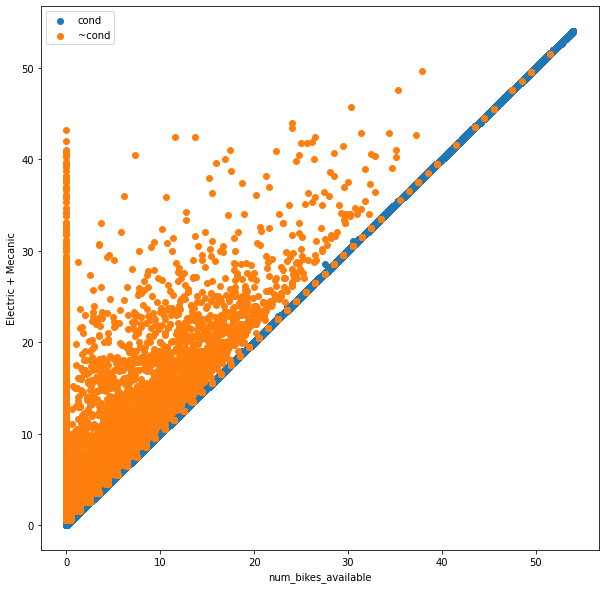

In [20]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())
    
plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [21]:
%%time

data[config_year.year]['num_bikes_available'] = data[config_year.year]['num_bikes_available'].mask(~cond, (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']))


CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 9.56 ms


correct data 4411603 incorrect data 0
CPU times: user 1.89 s, sys: 310 ms, total: 2.2 s
Wall time: 7.8 s


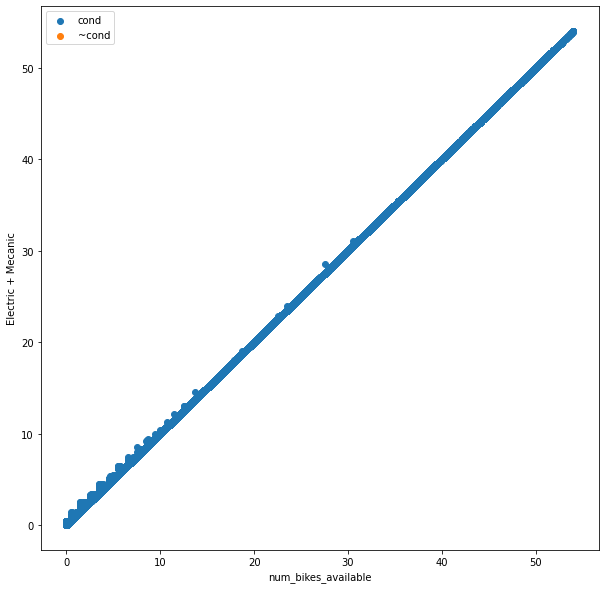

In [22]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())

plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [23]:
# Now capacity of a station must be something similar to the sum of available bikes and available docks

In [24]:
%%time

data[config_year.year]['capacity'] = data[config_year.year].num_bikes_available + data[config_year.year].num_docks_available

stations_max_capacity = data[config_year.year].groupby(['station_id'])['capacity'].max().reset_index()

# drop capacity 
data[config_year.year] = data[config_year.year].drop(['capacity'], axis=1)

# merge with stations_max_capacity
data[config_year.year] = data[config_year.year].merge(stations_max_capacity.copy(), how='left', on=['station_id'])


CPU times: user 17.8 ms, sys: 9.74 ms, total: 27.6 ms
Wall time: 28.9 ms


In [25]:
%%time

print(stats.describe(data[config_year.year]['capacity']))
data[config_year.year]['capacity'].describe().compute()

DescribeResult(nobs=4411603, minmax=(12.000000000000004, 54.000000000000014), mean=27.06908259877419, variance=39.21044578404506, skewness=1.289283684272652, kurtosis=3.635553583208196)
CPU times: user 742 ms, sys: 156 ms, total: 898 ms
Wall time: 3.38 s


count    4.411603e+06
mean     2.706908e+01
std      6.261824e+00
min      1.200000e+01
25%      2.400000e+01
50%      2.700000e+01
75%      2.900000e+01
max      5.400000e+01
Name: capacity, dtype: float64

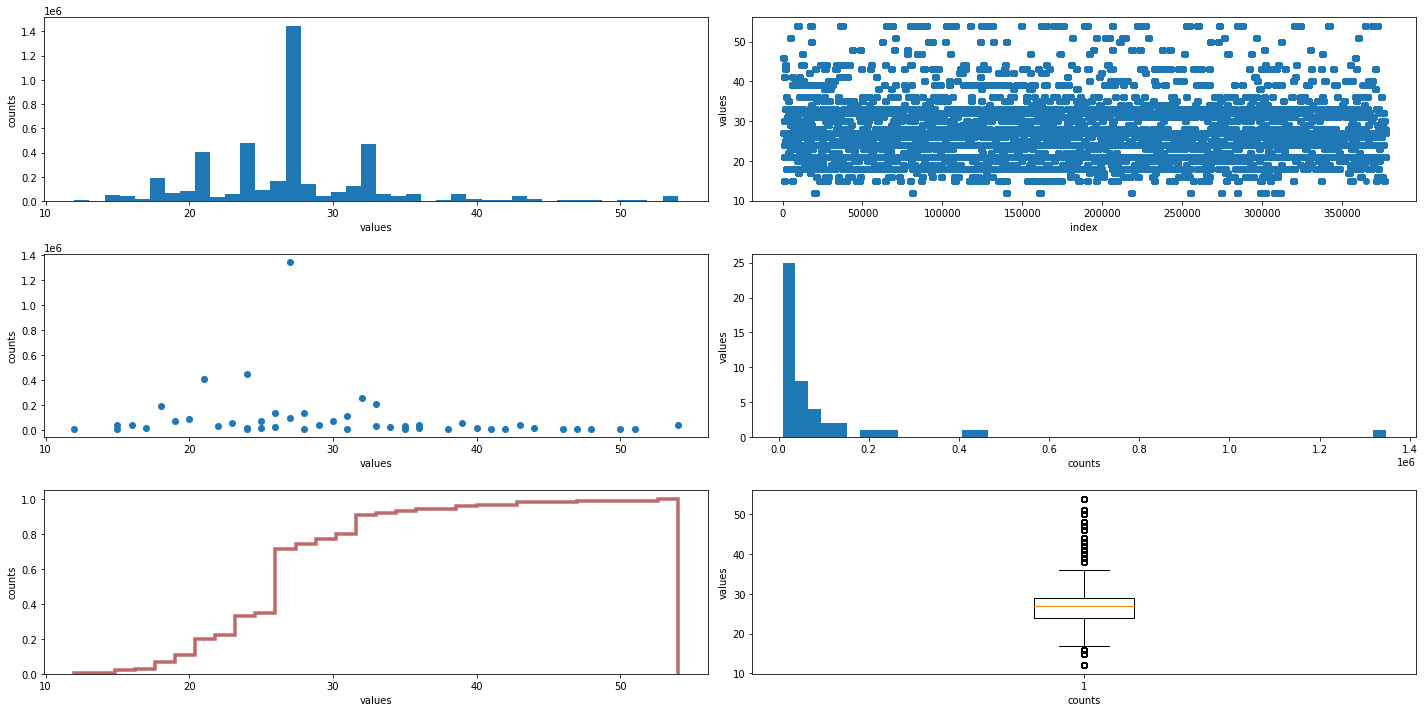

CPU times: user 8.16 s, sys: 1.14 s, total: 9.29 s
Wall time: 9.14 s


In [26]:
%%time

show_counts(data[config_year.year]['capacity'].compute())

## find the percentage of docks available

In [27]:
%%time

data[config_year.year]['ctx0'] = data[config_year.year].num_docks_available / data[config_year.year].capacity


CPU times: user 9.39 ms, sys: 0 ns, total: 9.39 ms
Wall time: 9.48 ms


In [28]:
%%time

print(stats.describe(data[config_year.year]['ctx0']))
data[config_year.year]['ctx0'].describe().compute()

DescribeResult(nobs=4411603, minmax=(0.0, 0.9999999999999998), mean=0.5853444554211286, variance=0.07780183036723641, skewness=-0.4438377514446695, kurtosis=-0.9162956363632411)
CPU times: user 819 ms, sys: 170 ms, total: 989 ms
Wall time: 3.48 s


count    4.411603e+06
mean     5.853445e-01
std      2.789298e-01
min      0.000000e+00
25%      3.990385e-01
50%      6.759259e-01
75%      8.545455e-01
max      1.000000e+00
Name: ctx0, dtype: float64

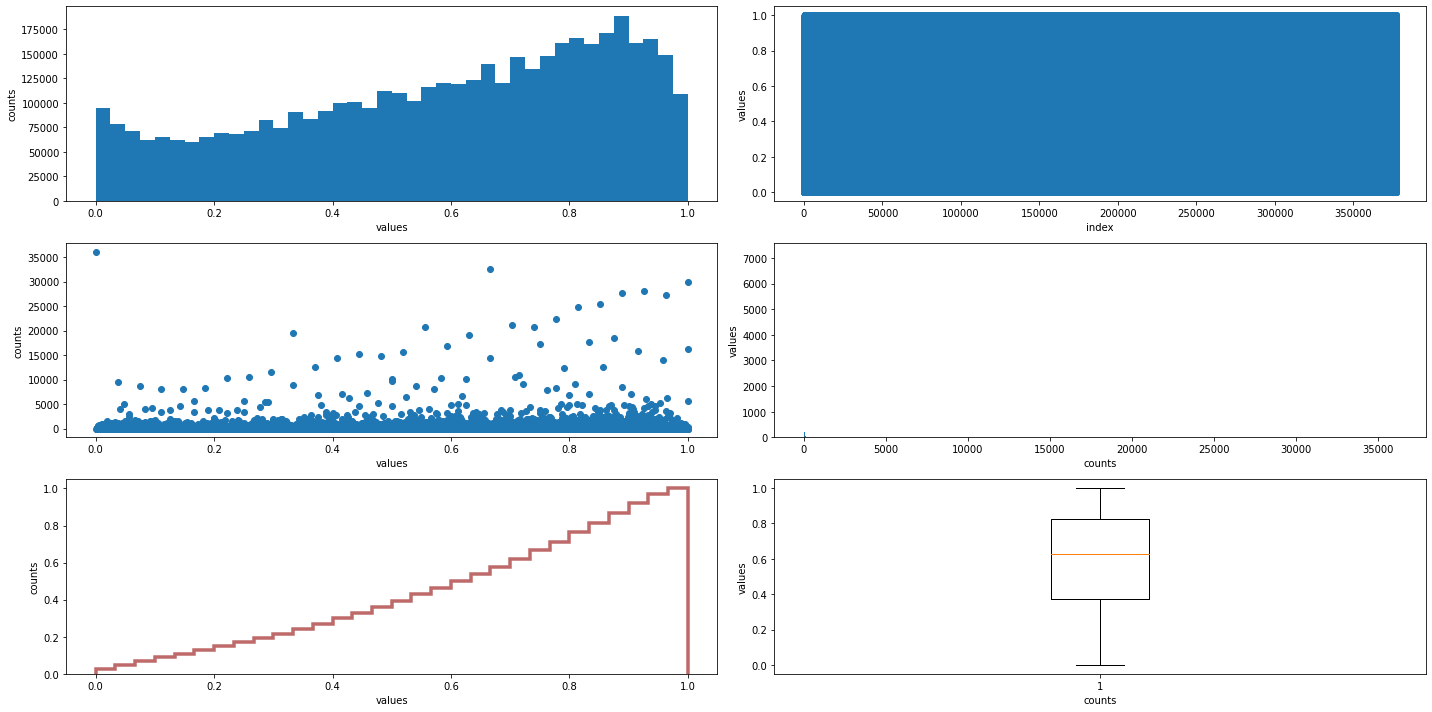

CPU times: user 1min 18s, sys: 11.3 s, total: 1min 29s
Wall time: 1min 28s


In [29]:
%%time

show_counts(data[config_year.year]['ctx0'].compute())

### Generating new columns of past 4 hours

In [30]:
%%time

ctx = data[config_year.year][['station_id', 'timestamp', 'ctx0']].copy()
# ctx = ctx.rename(columns={'num_docks_available': 'ctx0'})
print(ctx.columns)

for i in range(1,5): 
    ctx = ctx.rename(columns={f'ctx{i-1}': f'ctx{i}'})
    print(ctx.columns)
    
    ctx.timestamp = ctx.timestamp + 3600 
    data[config_year.year] = data[config_year.year].merge(ctx.copy(), how='left', on=['station_id','timestamp'])
    
    cond = data[config_year.year][f'ctx{i}'].isna()
    data[config_year.year][f'ctx{i}'] = data[config_year.year][f'ctx{i}'].mask(cond, data[config_year.year][f'ctx{i-1}'])


Index(['station_id', 'timestamp', 'ctx0'], dtype='object')
Index(['station_id', 'timestamp', 'ctx1'], dtype='object')
Index(['station_id', 'timestamp', 'ctx2'], dtype='object')
Index(['station_id', 'timestamp', 'ctx3'], dtype='object')
Index(['station_id', 'timestamp', 'ctx4'], dtype='object')
CPU times: user 171 ms, sys: 29.1 ms, total: 200 ms
Wall time: 194 ms


In [31]:
data[config_year.year].columns

Index(['station_id', 'num_bikes_available',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_charging_station', 'status', 'is_installed', 'is_renting',
       'is_returning', 'timestamp', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [32]:
%%time

get_features_nans(data[config_year.year])

CPU times: user 9.64 s, sys: 529 ms, total: 10.2 s
Wall time: 22.9 s


{}

In [33]:
%%time

save_checkpoint(data[config_year.year], config_year)

# checkpoint saved.

checkpoint saved.
CPU times: user 3.52 s, sys: 259 ms, total: 3.78 s
Wall time: 33.1 s
